In [1]:
from qwak.qwak import QWAK
import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp
import os


In [2]:
def getWeightedGraph(graph,weight):
    revGraph = graph.reverse()
    for u,v,d in graph.edges(data=True):
        d["weight"] = weight
    for u,v,d in revGraph.edges(data=True):
        d["weight"] = np.conj(weight)
    return nx.compose(graph,revGraph)

def multiple_oriented_decayRate(N,k,timeList,baseGraph,alphaList,initCond):
    decayRateMatrix = []
    for alpha in alphaList:
        weight = np.exp(1j*alpha)
        graph = getWeightedGraph(baseGraph,weight)
        qw = QWAK(graph)
        qw.runMultipleWalks(timeList=timeList,customStateList=initCond)
        decayRateMatrix.append(qw.getSurvivalProbList(N//2-k-1,N//2+k+2))
    return decayRateMatrix

def write_nested_list_to_file(file_path, nested_lst):
    """
    Write a nested list of elements to a text file.
    
    :param file_path: the file path where to write the nested list
    :param nested_lst: the nested list of elements to write
    """
    with open(file_path, 'w') as f:
        for lst in nested_lst:
            for item in lst:
                f.write(f"{item} ")
            f.write("\n")

def load_nested_list_from_file(file_path):
    """
    Load a nested list of float elements from a text file.
    
    :param file_path: the file path to load the nested list from
    :return: the nested list of float elements loaded from the file
    """
    nested_lst = []
    with open(file_path, 'r') as f:
        for line in f:
            lst = [float(item) for item in line.strip().split()]
            nested_lst.append(lst)
    return nested_lst

In [14]:
n = 10
N=2**n
print(N)

alpha=np.pi/2
alphaList = [0, alpha/2, alpha/3]
alphaLabelList = [r'$0$',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$']

baseGraph = nx.path_graph(N,create_using=nx.DiGraph)

k = 3
if k > 0:
    theta=np.pi/4
else:
    theta = np.pi/2
    
l = 0
gamma = l * np.pi

t = 100
samples = 500
timeList = np.linspace(1,t,samples)
initCond = [(N//2-k,np.cos(theta)),(N//2+k,np.exp(1j*gamma)*np.sin(theta))]

1024


In [15]:
decayRateMatrix_file = f'Datasets/OrientedDecayRate/decayRateMatrix{N}_NWALKS{len(alphaList)}_S{samples}_TMAX{t}.txt'

if os.path.exists(decayRateMatrix_file):
    decayRateMatrix = load_nested_list_from_file(decayRateMatrix_file)
    print('File exists!')
else:
    print('File Doesnt Exist!')
    decayRateMatrix = multiple_oriented_decayRate(N,k,timeList,baseGraph,alphaList,initCond)
    if not os.path.exists(decayRateMatrix_file):
        write_nested_list_to_file(decayRateMatrix_file, decayRateMatrix)

File Doesnt Exist!


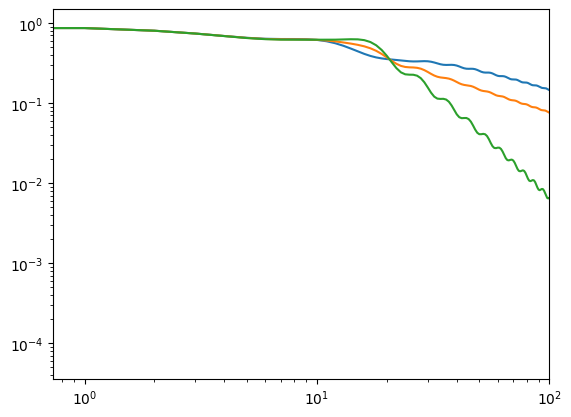

In [16]:
for x in decayRateMatrix:
    plt.loglog()
    plt.plot(x)
    plt.xlim([0,100])
   